In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 20

# Data Visualization

In [2]:
root_dir = '/Users/tahmit/Desktop/math381/data_project/final_project/img/'

In [4]:
# Load the data and column descriptions.
df = pd.read_csv('featured_nsfg_data.csv')
with open('2015_2017_FemPregData.pickle', 'rb') as fs:
    cols = pickle.load(fs)
df.drop(columns=['Unnamed: 0', 'const'], inplace=True)

Using the data set, we can extrapolate the estimated percent of all 
pregnancies ending in miscarriage in the U.S. in the years 2015-2017. We use the weight column to properly weight each survey response.

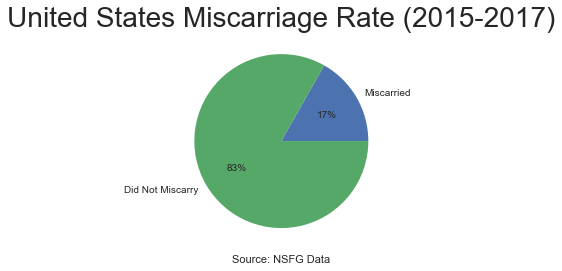

In [5]:
num_miscarriages = (df['OUTCOME_MISCARRIAGE']*df['WGT2015_2017']).sum()
tot_pregnancies = df['WGT2015_2017'].sum()
prop_miscarry = num_miscarriages / tot_pregnancies
plt.pie([prop_miscarry,1-prop_miscarry],autopct='%1.f%%',labels=['Miscarried','Did Not Miscarry'])
plt.title('United States Miscarriage Rate (2015-2017)',fontsize=28)
plt.xlabel('Source: NSFG Data')
plt.savefig(root_dir+'USMiscarriageRate.png',)

A little under 20% of all pregnancies end in miscarriage. This is right in line with the literature, about what we would expect to get. So, lets see if any of our other data columns are correlated with this. We will plot the correlation matrix for all columns to try to get an idea of if any columns seem very highly correlated.

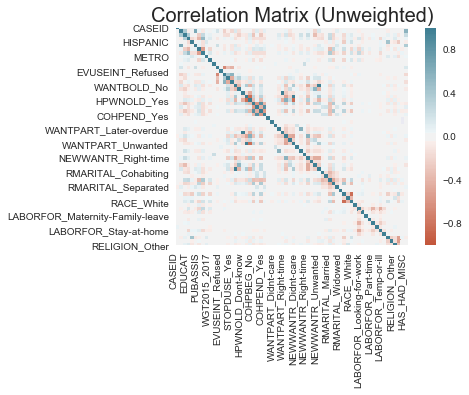

In [6]:
# Plot the correlation matrix for the most correlated columns
corr = df.corr()
top_corr = [(x[0],x[1]) for x in corr['BORNALIV'].iteritems() if abs(x[1]) > 0.4]
ax = sns.heatmap(
    corr.drop(labels=[x[0] for x in top_corr]).drop(columns=[x[0] for x in top_corr]),
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
plt.title('Correlation Matrix (Unweighted)',fontsize=20)
plt.savefig(root_dir+'full_corr_mat_unweighted.png')

We will plot the top correlation values of columns that are correlated with whether a baby was born alive or not.

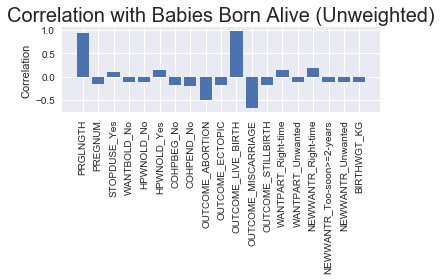

In [7]:
# Plot correlation values with the pregnancy loss column
top_corr = [(x[0],x[1]) for x in corr['BORNALIV'].iteritems() if abs(x[1]) > 0.08]
ax = plt.figure()
plt.title('Correlation with Babies Born Alive (Unweighted)',fontsize=20)
plt.bar(x=np.arange(len(top_corr)-1), height=[x[1] for x in top_corr if x[0] != 'BORNALIV'])
plt.ylabel('Correlation')
plt.xticks(np.arange(len(top_corr)-1), [x[0] for x in top_corr if x[0] != 'BORNALIV'], rotation=90)
plt.tight_layout()
plt.savefig(root_dir+'bbaliv_corr_mat_unweighted.png',)

Now, we will plot the top correlation values with the miscarriage column.

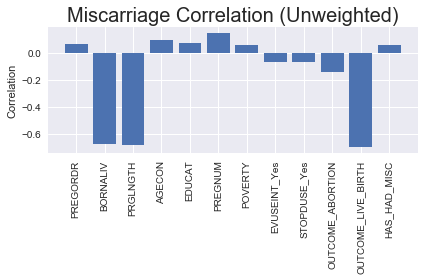

In [8]:
# Plot correlation values with just the miscarriage column
top_corr = [(x[0],x[1]) for x in corr['OUTCOME_MISCARRIAGE'].iteritems() if abs(x[1]) > 0.06]
ax = plt.figure()
plt.title('Miscarriage Correlation (Unweighted)',fontsize=20)
plt.bar(x=np.arange(len(top_corr)-1), height=[x[1] for x in top_corr if x[0] != 'OUTCOME_MISCARRIAGE'])
plt.ylabel('Correlation')
plt.xticks(np.arange(len(top_corr)), [x[0] for x in top_corr if x[0] != 'OUTCOME_MISCARRIAGE'], rotation=90)
plt.tight_layout()
plt.savefig(root_dir+'miscarriage_corr_mat_unweighted.png')

We note that the correlations above are quite small, except for some of the obvious, trivial correlations (like pregnancy length and miscarriage). We also want to compute correlation that is properly weighted, and hopefully we'll get larger correlations. To do so, we implement a weighted Pearson correlation function.

In [9]:
from math import sqrt

def w_mean(x,w):
    """Computes the weighted mean of data x with weights w."""
    if x.size != w.size:
        return None
    return np.sum(x*w)/np.sum(w)

def w_cov(x,y,w):
    """Computes the weighted covariance of data x,y with weights w."""
    m_X = w_mean(x,w)
    m_Y = w_mean(y,w)
    if m_X is None or m_Y is None:
        return None
    return np.sum(w*(x-m_X)*(y-m_Y))/np.sum(w)

def w_corr(x,y,w):
    """Computes the weighted Pearson correlation between data x,y 
    with weights w.
    """
    s_XY = w_cov(x,y,w)
    s_X = w_cov(x,x,w)
    s_Y = w_cov(y,y,w)
    if s_XY is None or s_X is None or s_Y is None:
        return None
    return s_XY/sqrt(s_X*s_Y)

In [10]:
# Compute miscarriage correlations with each other column
weighted_pearson = lambda x,y: w_corr(x,y,df['WGT2015_2017'].values)
weighted_misc_corr = df.corrwith(df['OUTCOME_MISCARRIAGE'], method=weighted_pearson, drop=True)
# Compute babies born alive correlations with each other column
weighted_bornaliv_corr = df.corrwith(df['BORNALIV'], method=weighted_pearson, drop=True)

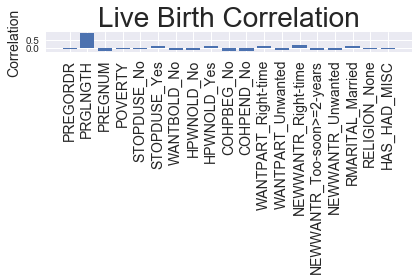

In [11]:
# Plot correlation values with the pregnancy loss column
top_corr = [(x[0],x[1]) for x in weighted_bornaliv_corr.iteritems() if (abs(x[1]) > 0.07 and not x[0].startswith('OUTCOME'))]
ax = plt.figure()
plt.title('Live Birth Correlation',fontsize=28)
plt.bar(x=np.arange(len(top_corr)-1), height=[x[1] for x in top_corr if x[0] != 'BORNALIV'])
plt.ylabel('Correlation', fontsize=14)
plt.xticks(np.arange(len(top_corr)-1), [x[0] for x in top_corr if x[0] != 'BORNALIV'], rotation=90, fontsize=14)
plt.tight_layout()
plt.savefig(root_dir+'bbaliv_corr_mat.png',)

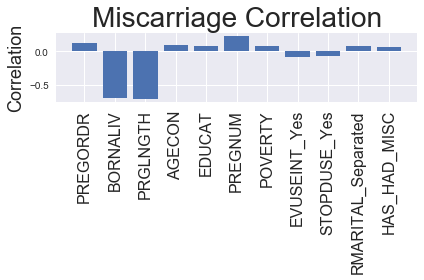

In [12]:
# Plot correlation values with just the miscarriage column
top_corr = [(x[0],x[1]) for x in weighted_misc_corr.iteritems() if (abs(x[1]) > 0.07 and not x[0].startswith('OUTCOME'))]
ax = plt.figure()
plt.title('Miscarriage Correlation',fontsize=28)
plt.bar(x=np.arange(len(top_corr)), height=[x[1] for x in top_corr if x[0] != 'OUTCOME_MISCARRIAGE'])
plt.ylabel('Correlation',fontsize=18)
plt.xticks(np.arange(len(top_corr)), [x[0] for x in top_corr if x[0] != 'OUTCOME_MISCARRIAGE'], rotation=90,fontsize=16)
plt.tight_layout()
plt.savefig(root_dir+'miscarriage_corr_mat.png')

From the previous two graphs, we see that some of the most highly correlated variables with miscarriage are rather obvious: being born alive, pregnancy length, and the other possible outcomes of the pregnancy. Some more interesting correlations include past miscarriages, age at conception, education, which pregnancy this is (e.g. 1st, 2nd...), and poverty. 

A baby being born alive (i.e. not abortion, ectopic pregnancy, miscarriage, or other) has most of the same highly correlated values, but is also significantly correlated with use of birth control and whether the baby was wanted, which are some very intriguing variables.

We want to look at some the distributions of all the different variables.

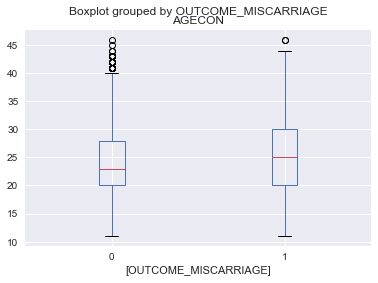

In [15]:
df[['OUTCOME_MISCARRIAGE','AGECON']].boxplot(by='OUTCOME_MISCARRIAGE', figsize=(6,4))
plt.show()

In [16]:
miscarried = df.loc[df['OUTCOME_MISCARRIAGE'] == 1]
did_not_miscarry = df.loc[df['OUTCOME_MISCARRIAGE'] == 0]

In [17]:
# Include code to obtain weighted violin plots
# This code was obtained from 
# https://colab.research.google.com/drive/1cSnJGKJEqbllkPbF2z0cnfdwT40sUKKR#scrollTo=uv32Zda0JVwB
!pip install wquantiles

In [18]:
import weighted
from matplotlib.cbook import violin_stats
from scipy import stats
import statsmodels.api as sm
import numpy as np

def vdensity_with_weights(weights):
    ''' Outer function allows innder function access to weights. Matplotlib
    needs function to take in data and coords, so this seems like only way
    to 'pass' custom density function a set of weights '''
    
    def vdensity(data, coords):
        ''' Custom matplotlib weighted violin stats function '''
        # Using weights from closure, get KDE fomr statsmodels
        weighted_cost = sm.nonparametric.KDEUnivariate(data)
        weighted_cost.fit(fft=False, weights=weights)

        # Return y-values for graph of KDE by evaluating on coords
        return weighted_cost.evaluate(coords)
    return vdensity

def custom_violin_stats(data, weights):
    # Get weighted median and mean (using weighted module for median)
    median = weighted.quantile_1D(data, weights, 0.5)
    mean, sumw = np.ma.average(data, weights=list(weights), returned=True)
    
    # Use matplotlib violin_stats, which expects a function that takes in data and coords
    # which we get from closure above
    results = violin_stats(data, vdensity_with_weights(weights))
    
    # Update result dictionary with our updated info
    results[0][u"mean"] = mean
    results[0][u"median"] = median
    
    # No need to do this, since it should be populated from violin_stats
    # results[0][u"min"] =  np.min(data)
    # results[0][u"max"] =  np.max(data)

    return results

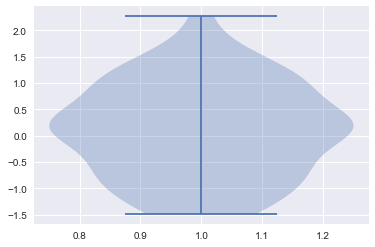

In [19]:
# Example of how to use weighted violin plots
SIZE = 100
x = np.random.normal(size=SIZE)
w = np.random.randint(1, 10, size=SIZE) * 1.
vpstats1 = custom_violin_stats(x, w)
fig, ax = plt.subplots()
vplot = ax.violin(vpstats1)

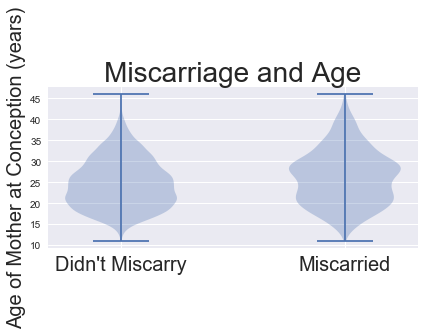

In [20]:
agecon_miscarry_weighted = custom_violin_stats(miscarried['AGECON'].values, 
                                               miscarried['WGT2015_2017'].values)[0]
agecon_nomiscarry_weighted = custom_violin_stats(did_not_miscarry['AGECON'].values, 
                                               did_not_miscarry['WGT2015_2017'].values)[0]
fig, ax = plt.subplots()
vpstats1 = ax.violin([agecon_nomiscarry_weighted, agecon_miscarry_weighted])
plt.ylabel('Age of Mother at Conception (years)',fontsize=20)
plt.xticks([1,2],["Didn't Miscarry", 'Miscarried'],fontsize=20)
plt.title('Miscarriage and Age',fontsize=28)
plt.tight_layout()
plt.savefig(root_dir+'agecon_violin.png')

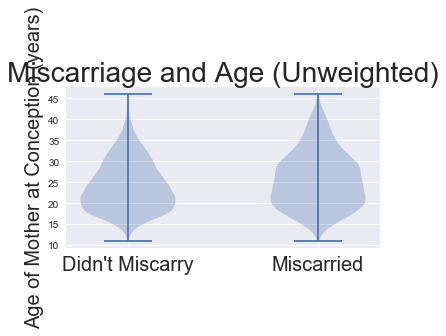

In [21]:
plt.figure()
plt.violinplot([did_not_miscarry['AGECON'].values, miscarried['AGECON'].values])
plt.ylabel('Age of Mother at Conception (years)',fontsize=20)
plt.xticks([1,2],["Didn't Miscarry", 'Miscarried'],fontsize=20)
plt.title('Miscarriage and Age (Unweighted)',fontsize=28)
plt.tight_layout()
plt.savefig(root_dir+'agecon_violin_unweighted.png')

The above boxplot and violin plot indicate that there are somewhat higher likelihoods of having a miscarriage based on age. An interesting idea for further examination might be to look at these same plots after normalizing for number of pregnancies at a specific age.

The following plot examines miscarriage based on pregnancy order. We might ask, is someone more likely to have a miscarriage if this is a later pregnancy (i.e. a 6th pregnancy rather than a 1st pregnancy)?

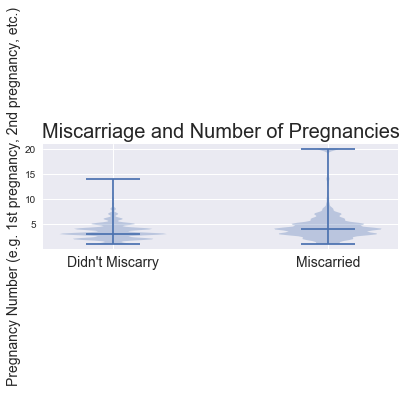

In [22]:
pregnum_miscarry_weighted = custom_violin_stats(miscarried['PREGNUM'].values, 
                                               miscarried['WGT2015_2017'].values)[0]
pregnum_nomiscarry_weighted = custom_violin_stats(did_not_miscarry['PREGNUM'].values, 
                                               did_not_miscarry['WGT2015_2017'].values)[0]
fig, ax = plt.subplots()
vpstats1 = ax.violin([pregnum_nomiscarry_weighted, pregnum_miscarry_weighted],showmedians=True)
plt.ylabel('Pregnancy Number (e.g. 1st pregnancy, 2nd pregnancy, etc.)',fontsize=14)
plt.xticks([1,2],["Didn't Miscarry", 'Miscarried'],fontsize=14)
plt.title('Miscarriage and Number of Pregnancies',fontsize=20)
plt.tight_layout()

#plt.figure()
#plt.violinplot([did_not_miscarry['PREGORDR'].values, miscarried['PREGORDR'].values])
#plt.ylabel('Pregnancy Order (e.g. 1st pregnancy, 2nd pregnancy, etc.)')
#plt.xticks([1,2],["Didn't Miscarry", 'Miscarried'])
#plt.tight_layout()
plt.savefig(root_dir+'pregnum_violin.png')

The plot seems to indicate that miscarriages are more common in later pregnancies.

Let's examine some racial, ethnic, socioeconomic groups for differences in miscarriage.

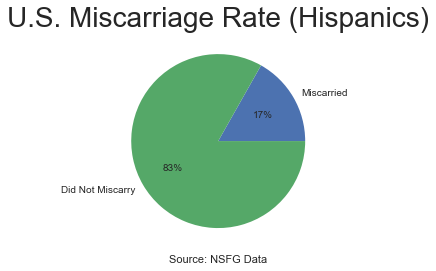

In [23]:
# Hispanic pregnancy rates
hispanic = df.loc[df['HISPANIC'] == 1]
not_hispanic = df.loc[df['HISPANIC'] == 0]

#hisp_miscarried = hispanic.loc[df['OUTCOME_MISCARRIAGE'] == 1]
#hisp_did_not_miscarry = hispanic.loc[df['OUTCOME_MISCARRIAGE'] == 0]

#not_hisp_miscarried = not_hispanic.loc[df['OUTCOME_MISCARRIAGE'] == 1]
#not_hisp_did_not_miscarry = not_hispanic.loc[df['OUTCOME_MISCARRIAGE'] == 0]

num_hisp_miscarriages = (hispanic['OUTCOME_MISCARRIAGE']*hispanic['WGT2015_2017']).sum()
tot_hisp_pregnancies = hispanic['WGT2015_2017'].sum()
prop_hisp_miscarry = num_hisp_miscarriages / tot_hisp_pregnancies
plt.pie([prop_miscarry,1-prop_miscarry],autopct='%1.f%%',labels=['Miscarried','Did Not Miscarry'])
plt.title('U.S. Miscarriage Rate (Hispanics)',fontsize=28)
plt.xlabel('Source: NSFG Data')
plt.savefig(root_dir+'USMiscarriageRateHispanic.png',)

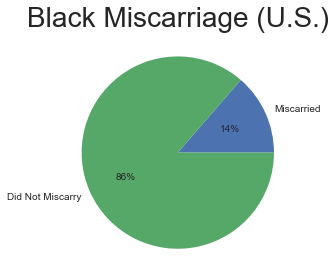

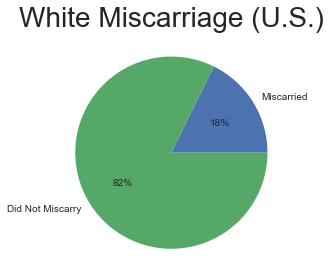

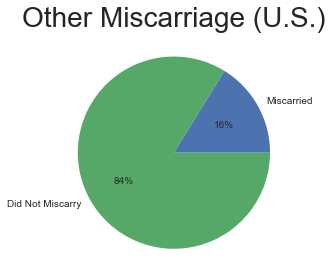

In [24]:
for i,race in enumerate(['RACE_Black', 'RACE_White', 'RACE_Other']):
    plt.figure()
    plt.title(f'{race[5:]} Miscarriage (U.S.)',fontsize=28)
    df_race = df.loc[df[race] == 1]
    pct_race_miscarried = (df_race['OUTCOME_MISCARRIAGE']*df_race['WGT2015_2017']).sum()/(df_race['WGT2015_2017'].sum())
    plt.pie([pct_race_miscarried,1-pct_race_miscarried],autopct='%1.f%%',labels=['Miscarried','Did Not Miscarry'])
    plt.tight_layout()
    plt.savefig(root_dir+f'/miscarriage_rate_{race[5:]}.png')

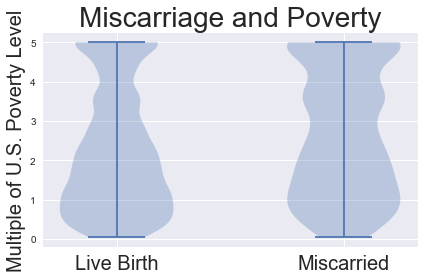

In [25]:
baby_born_alive = df.loc[df['BORNALIV'] == 1]
poverty_miscarry_weighted = custom_violin_stats(miscarried['POVERTY'].values, 
                                               miscarried['WGT2015_2017'].values)[0]
poverty_nomiscarry_weighted = custom_violin_stats(baby_born_alive['POVERTY'].values, 
                                               baby_born_alive['WGT2015_2017'].values)[0]
fig, ax = plt.subplots()
vpstats1 = ax.violin([poverty_nomiscarry_weighted, poverty_miscarry_weighted])
plt.ylabel('Multiple of U.S. Poverty Level',fontsize=20)
plt.xticks([1,2],["Live Birth", 'Miscarried'],fontsize=20)
plt.title('Miscarriage and Poverty',fontsize=28)
plt.tight_layout()
plt.savefig(root_dir+'poverty_violin.png')

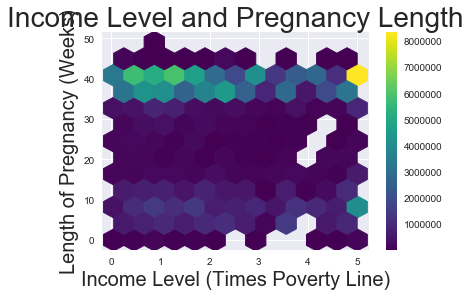

In [26]:
#df.plot(kind='hexbin', y='PRGLNGTH', x='POVERTY',gridsize=12,sharex=False)
plt.hexbin(df['POVERTY'].values,df['PRGLNGTH'].values,C=df['WGT2015_2017'],reduce_C_function=np.sum,gridsize=12,cmap='viridis')
plt.colorbar()
plt.xlabel('Income Level (Times Poverty Line)',fontsize=20)
plt.ylabel('Length of Pregnancy (Weeks)',fontsize=20)
plt.title('Income Level and Pregnancy Length',fontsize=28)
plt.savefig(root_dir+'income_preglength_hexbin.png')

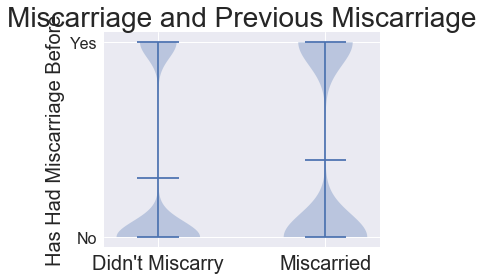

In [27]:
has_had_miscarry_weighted = custom_violin_stats(miscarried['HAS_HAD_MISC'].values, 
                                               miscarried['WGT2015_2017'].values)[0]
has_had_nomiscarry_weighted = custom_violin_stats(did_not_miscarry['HAS_HAD_MISC'].values, 
                                               did_not_miscarry['WGT2015_2017'].values)[0]
fig, ax = plt.subplots()
vpstats1 = ax.violin([has_had_nomiscarry_weighted, has_had_miscarry_weighted],showmeans=True)
plt.ylabel('Has Had Miscarriage Before',fontsize=20)
plt.xticks([1,2],["Didn't Miscarry", 'Miscarried'],fontsize=20)
plt.yticks([0,1],['No', 'Yes'],fontsize=16)
plt.title('Miscarriage and Previous Miscarriage',fontsize=28)
plt.tight_layout()
plt.savefig(root_dir+'prevmisc_violin.png')

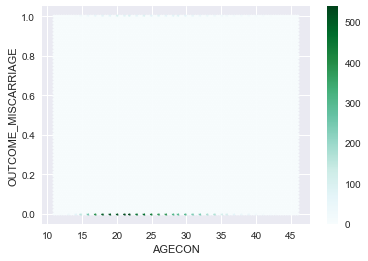

In [28]:
df.plot(kind='hexbin',x='AGECON',y='OUTCOME_MISCARRIAGE',sharex=False)

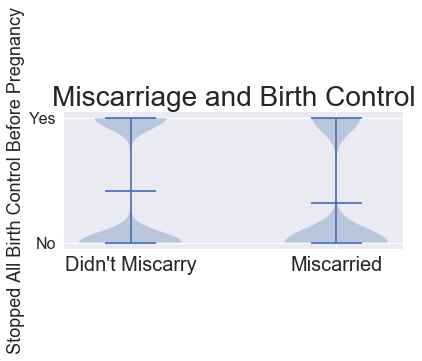

In [29]:
_miscarry_weighted = custom_violin_stats(miscarried['STOPDUSE_Yes'].values, 
                                               miscarried['WGT2015_2017'].values)[0]
_nomiscarry_weighted = custom_violin_stats(did_not_miscarry['STOPDUSE_Yes'].values, 
                                               did_not_miscarry['WGT2015_2017'].values)[0]
fig, ax = plt.subplots()
vpstats1 = ax.violin([_nomiscarry_weighted, _miscarry_weighted],showmeans=True)
plt.ylabel('Stopped All Birth Control Before Pregnancy',fontsize=18)
plt.xticks([1,2],["Didn't Miscarry", 'Miscarried'],fontsize=20)
plt.yticks([0,1],['No', 'Yes'],fontsize=16)
plt.title('Miscarriage and Birth Control',fontsize=28)
plt.tight_layout()
plt.savefig(root_dir+'birthcontrol_violin.png')